In [1]:
!git clone https://github.com/RInkalshah93/ERA-V2-Support.git

Cloning into 'ERA-V2-Support'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 35 (delta 13), reused 29 (delta 7), pack-reused 0
Receiving objects: 100% (35/35), 6.66 KiB | 6.66 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
!pip install grad-cam
!pip install torch-lr-finder
!pip install torchsummary


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#import model
import matplotlib.pyplot as plt
import numpy as np
%cd ERA-V2-Support
from Model.model_10 import Model_10
import dataset
import train
import utils



/content/ERA-V2-Support


In [4]:
SEED = 1


cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

train_data = dataset.train()
test_data = dataset.test()
if cuda:
    batch_size = 512
    shuffle = True
    num_workers = 4
    pin_memory = True
    train_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,train_data)
    test_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,test_data)
else:
    batch_size =256
    shuffle = True
    num_workers =2
    pin_memory = True
    train_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,train_data)
    test_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,test_data)


CUDA Available? True


100%|██████████| 170498071/170498071 [00:13<00:00, 12983606.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


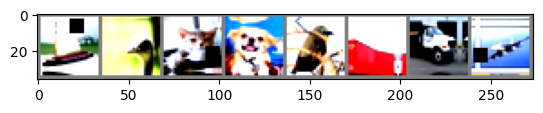

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ship  bird  cat   dog  


In [5]:
# functions to show an image
utils.plot_image(train_loader)

In [6]:
device = utils.get_device()
model = Model_10().to(device)
utils.model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.85E-04


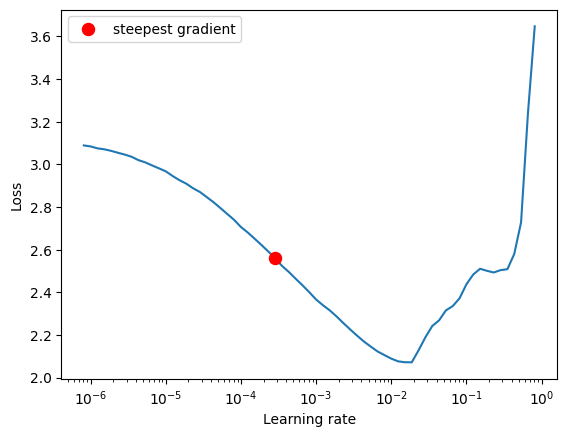

In [7]:
criterion = nn.CrossEntropyLoss()
max_lr, optimizer = utils.get_max_lr(model, train_loader,criterion)

In [8]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=10,
        three_phase=False,
        final_div_factor=1,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc, train_losses = train.train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test_acc, test_losses = train.test(model, device, test_loader, criterion)
    print("LR for current epoch: ",scheduler.get_last_lr())

EPOCH: 0


Loss=1.411300539970398 LR=7.984983999234115e-05 Batch_id=97 Accuracy=37.67: 100%|██████████| 98/98 [00:18<00:00,  5.37it/s]



Test set: Average loss: 0.0026, Accuracy: 5386/10000 (53.86%)

LR for current epoch:  [7.984983999234115e-05]
EPOCH: 1


Loss=1.1209917068481445 LR=0.00013121932130032428 Batch_id=97 Accuracy=56.19: 100%|██████████| 98/98 [00:18<00:00,  5.34it/s]



Test set: Average loss: 0.0023, Accuracy: 5998/10000 (59.98%)

LR for current epoch:  [0.00013121932130032428]
EPOCH: 2


Loss=1.0430090427398682 LR=0.00018258880260830745 Batch_id=97 Accuracy=64.23: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]



Test set: Average loss: 0.0019, Accuracy: 6734/10000 (67.34%)

LR for current epoch:  [0.00018258880260830745]
EPOCH: 3


Loss=0.8806301355361938 LR=0.00023395828391629058 Batch_id=97 Accuracy=69.85: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]



Test set: Average loss: 0.0018, Accuracy: 6944/10000 (69.44%)

LR for current epoch:  [0.00023395828391629058]
EPOCH: 4


Loss=0.6595190167427063 LR=0.000284665926678081 Batch_id=97 Accuracy=74.38: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]



Test set: Average loss: 0.0014, Accuracy: 7580/10000 (75.80%)

LR for current epoch:  [0.000284665926678081]
EPOCH: 5


Loss=0.6375137567520142 LR=0.00027117523045917455 Batch_id=97 Accuracy=77.76: 100%|██████████| 98/98 [00:19<00:00,  5.14it/s]



Test set: Average loss: 0.0012, Accuracy: 7984/10000 (79.84%)

LR for current epoch:  [0.00027117523045917455]
EPOCH: 6


Loss=0.537672758102417 LR=0.0002576845342402681 Batch_id=97 Accuracy=80.72: 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]



Test set: Average loss: 0.0012, Accuracy: 7939/10000 (79.39%)

LR for current epoch:  [0.0002576845342402681]
EPOCH: 7


Loss=0.504923939704895 LR=0.0002441938380213617 Batch_id=97 Accuracy=82.89: 100%|██████████| 98/98 [00:18<00:00,  5.20it/s]



Test set: Average loss: 0.0011, Accuracy: 8154/10000 (81.54%)

LR for current epoch:  [0.0002441938380213617]
EPOCH: 8


Loss=0.4348301589488983 LR=0.00023070314180245527 Batch_id=97 Accuracy=84.28: 100%|██████████| 98/98 [00:19<00:00,  5.14it/s]



Test set: Average loss: 0.0010, Accuracy: 8196/10000 (81.96%)

LR for current epoch:  [0.00023070314180245527]
EPOCH: 9


Loss=0.41280657052993774 LR=0.00021721244558354884 Batch_id=97 Accuracy=85.67: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]



Test set: Average loss: 0.0009, Accuracy: 8409/10000 (84.09%)

LR for current epoch:  [0.00021721244558354884]
EPOCH: 10


Loss=0.31007009744644165 LR=0.0002037217493646424 Batch_id=97 Accuracy=86.48: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]



Test set: Average loss: 0.0009, Accuracy: 8458/10000 (84.58%)

LR for current epoch:  [0.0002037217493646424]
EPOCH: 11


Loss=0.29732614755630493 LR=0.00019023105314573598 Batch_id=97 Accuracy=87.60: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]



Test set: Average loss: 0.0010, Accuracy: 8387/10000 (83.87%)

LR for current epoch:  [0.00019023105314573598]
EPOCH: 12


Loss=0.3297971487045288 LR=0.00017674035692682958 Batch_id=97 Accuracy=88.52: 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]



Test set: Average loss: 0.0008, Accuracy: 8619/10000 (86.19%)

LR for current epoch:  [0.00017674035692682958]
EPOCH: 13


Loss=0.3394704759120941 LR=0.00016324966070792315 Batch_id=97 Accuracy=89.29: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]



Test set: Average loss: 0.0008, Accuracy: 8694/10000 (86.94%)

LR for current epoch:  [0.00016324966070792315]
EPOCH: 14


Loss=0.2949267029762268 LR=0.00014975896448901673 Batch_id=97 Accuracy=90.06: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]



Test set: Average loss: 0.0008, Accuracy: 8693/10000 (86.93%)

LR for current epoch:  [0.00014975896448901673]
EPOCH: 15


Loss=0.2860812842845917 LR=0.00013626826827011033 Batch_id=97 Accuracy=90.80: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]



Test set: Average loss: 0.0007, Accuracy: 8741/10000 (87.41%)

LR for current epoch:  [0.00013626826827011033]
EPOCH: 16


Loss=0.27273547649383545 LR=0.0001227775720512039 Batch_id=97 Accuracy=91.39: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]



Test set: Average loss: 0.0007, Accuracy: 8722/10000 (87.22%)

LR for current epoch:  [0.0001227775720512039]
EPOCH: 17


Loss=0.2125246226787567 LR=0.00010928687583229744 Batch_id=97 Accuracy=92.34: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]



Test set: Average loss: 0.0007, Accuracy: 8750/10000 (87.50%)

LR for current epoch:  [0.00010928687583229744]
EPOCH: 18


Loss=0.247036412358284 LR=9.579617961339104e-05 Batch_id=97 Accuracy=93.09: 100%|██████████| 98/98 [00:19<00:00,  5.16it/s]



Test set: Average loss: 0.0009, Accuracy: 8640/10000 (86.40%)

LR for current epoch:  [9.579617961339104e-05]
EPOCH: 19


Loss=0.18157199025154114 LR=8.230548339448462e-05 Batch_id=97 Accuracy=93.70: 100%|██████████| 98/98 [00:19<00:00,  5.16it/s]



Test set: Average loss: 0.0007, Accuracy: 8797/10000 (87.97%)

LR for current epoch:  [8.230548339448462e-05]
EPOCH: 20


Loss=0.14427077770233154 LR=6.881478717557822e-05 Batch_id=97 Accuracy=94.50: 100%|██████████| 98/98 [00:19<00:00,  5.08it/s]



Test set: Average loss: 0.0007, Accuracy: 8908/10000 (89.08%)

LR for current epoch:  [6.881478717557822e-05]
EPOCH: 21


Loss=0.19617582857608795 LR=5.532409095667176e-05 Batch_id=97 Accuracy=95.28: 100%|██████████| 98/98 [00:18<00:00,  5.18it/s]



Test set: Average loss: 0.0006, Accuracy: 9010/10000 (90.10%)

LR for current epoch:  [5.532409095667176e-05]
EPOCH: 22


Loss=0.16041815280914307 LR=4.183339473776536e-05 Batch_id=97 Accuracy=95.83: 100%|██████████| 98/98 [00:18<00:00,  5.16it/s]



Test set: Average loss: 0.0005, Accuracy: 9073/10000 (90.73%)

LR for current epoch:  [4.183339473776536e-05]
EPOCH: 23


Loss=0.06986258924007416 LR=2.834269851885896e-05 Batch_id=97 Accuracy=96.64: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0006, Accuracy: 9053/10000 (90.53%)

LR for current epoch:  [2.834269851885896e-05]


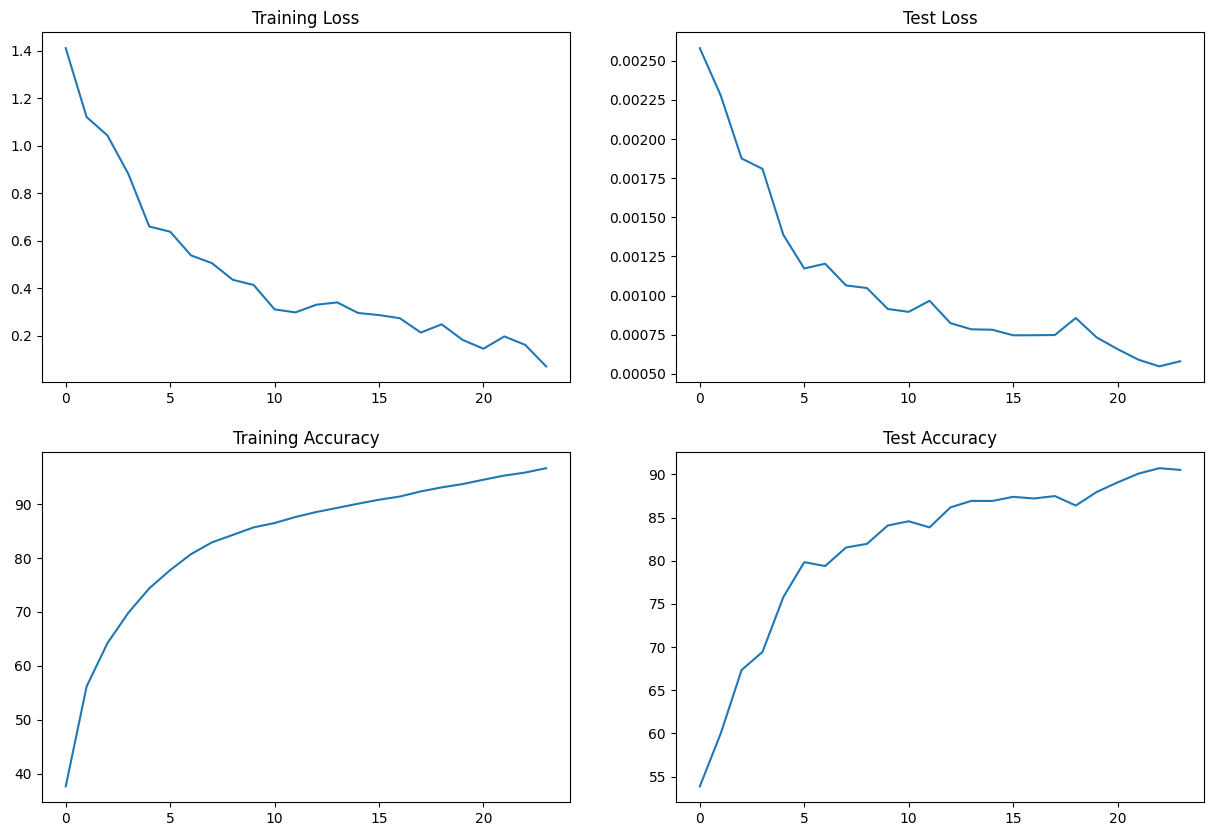

In [9]:
train.plot_loss_accuracy(train_losses,train_acc,test_losses,test_acc)

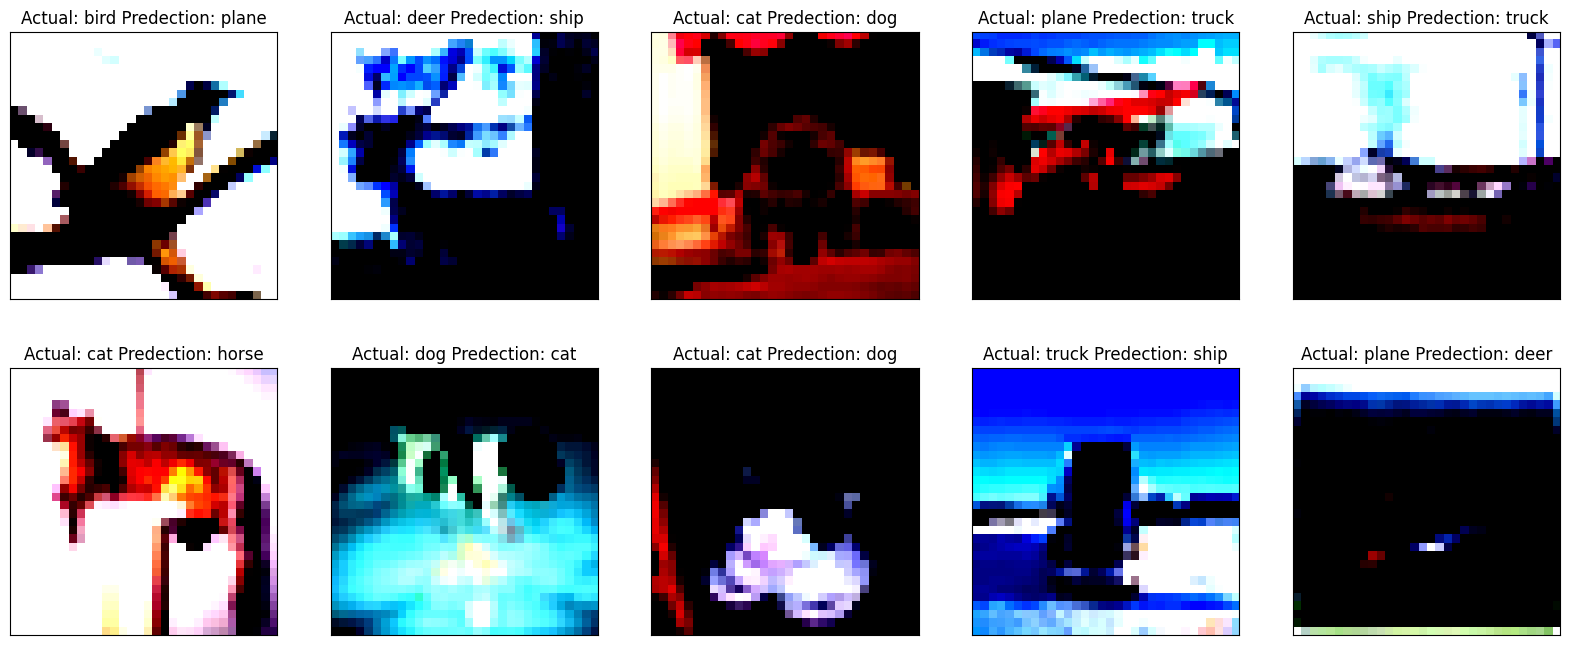

In [10]:
utils.plot_prediction_image(test_loader,device,model)